## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pprint import pprint
from src import calibration, utils, lane_detection, thresholding, config

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Camera Calibration

* camera calibrated
* chess-board image can be undistorted
* perspective transform can be applied to chess-board image
* perspective transform applied to road image

In [2]:
camera = calibration.Camera()
camera.calibrate(False)

WARNING Not all corners were found in data/camera_cal/calibration5.jpg, skipping...
WARNING Not all corners were found in data/camera_cal/calibration4.jpg, skipping...
WARNING Not all corners were found in data/camera_cal/calibration1.jpg, skipping...


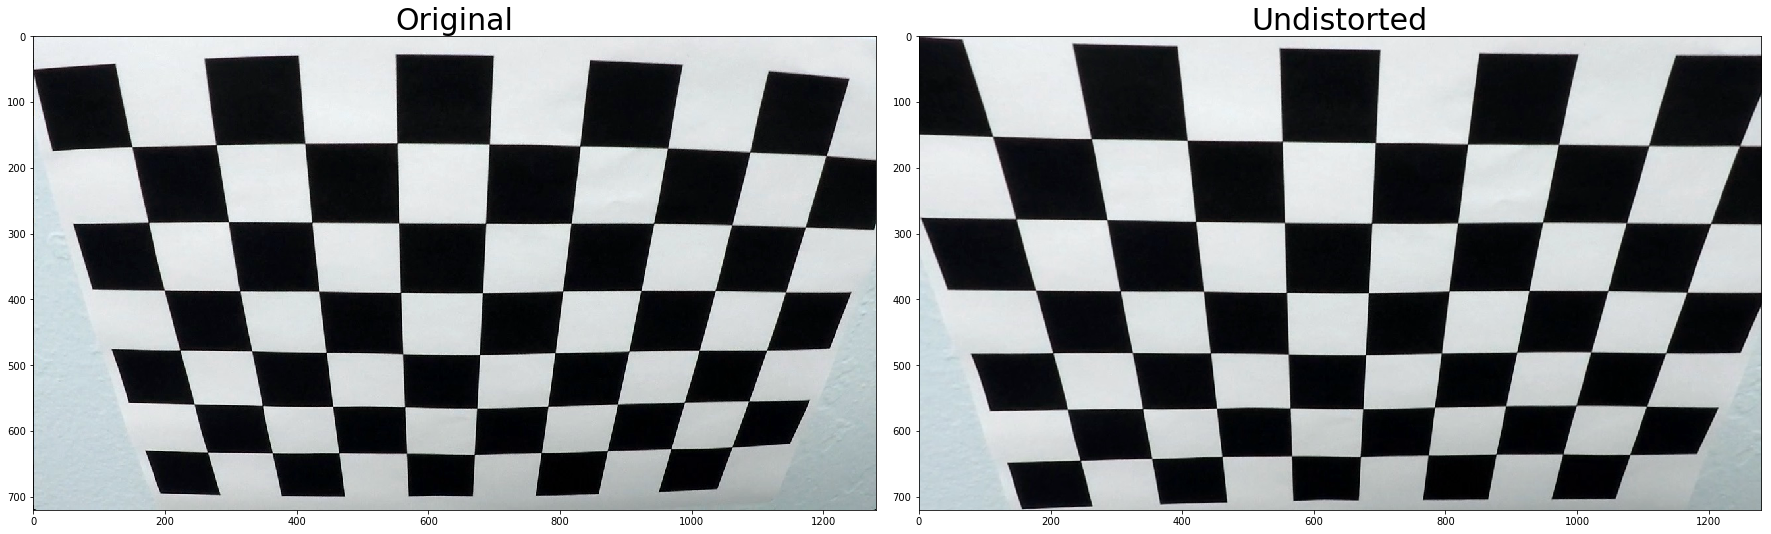

In [7]:
image_filename = 'data/camera_cal/calibration2.jpg'
img = cv2.imread(image_filename)

undistorted = camera.undistort(img)

utils.plot_images([(img, 'Original'), (undistorted, 'Undistorted')])
plt.savefig('output/images/calibration/distortion-correction-chess-board.jpg')

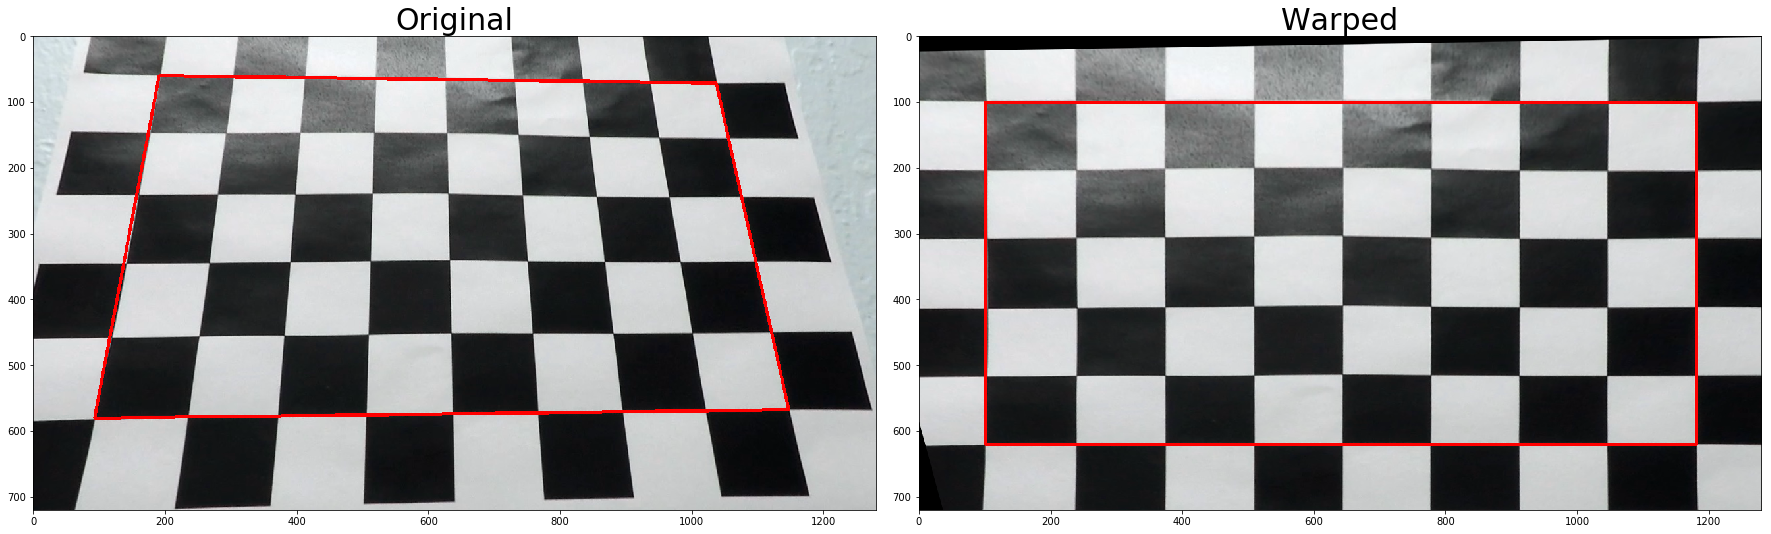

In [21]:
image_filename = 'data/camera_cal/calibration3.jpg'
img = cv2.imread(image_filename)

src, dst = camera.find_chess_board_perspective_transform_pts(img, 100)
overlaid, warped, _ = camera.perform_perspective_transform(img, src, dst)

utils.plot_images([(overlaid, 'Original'), (warped, 'Warped')])
plt.savefig('output/images/calibration/unwarp-chess-board.jpg')

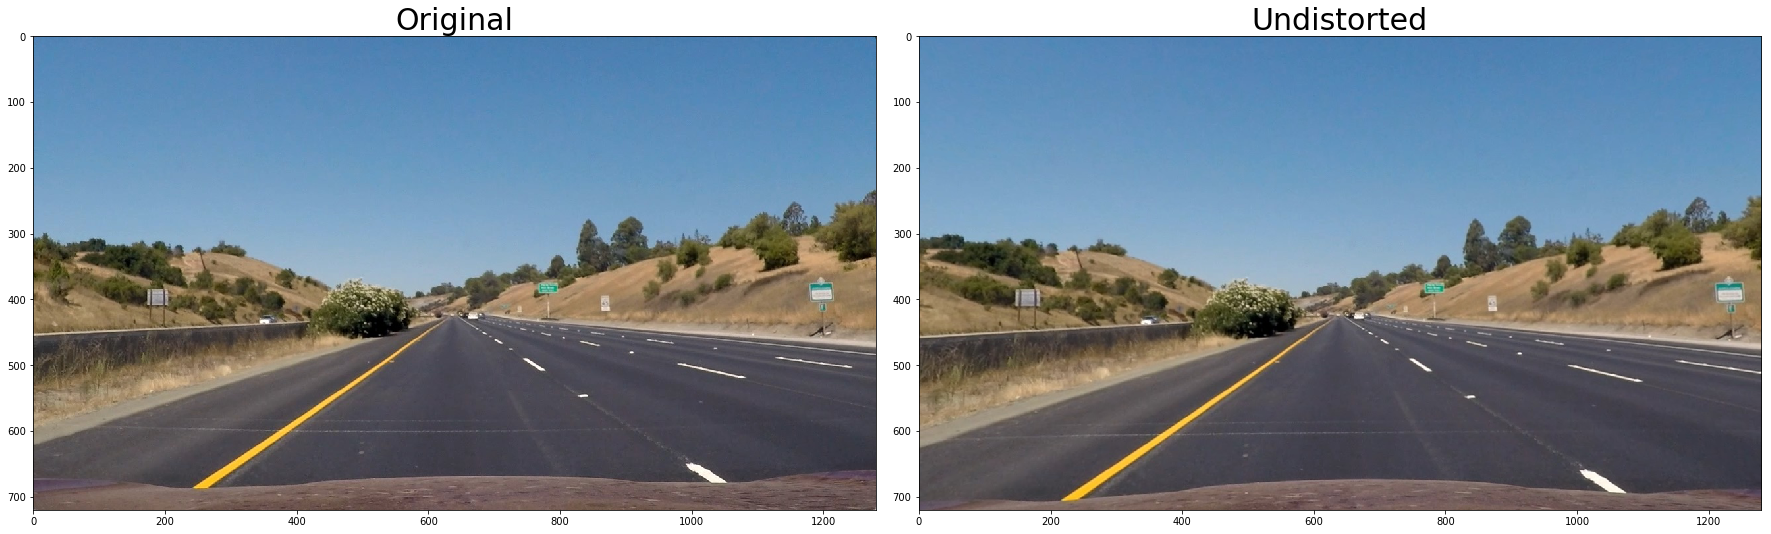

In [6]:
image_filename = 'data/images/straight_lines1.jpg'
img = mpimg.imread(image_filename)

undistorted = camera.undistort(img)

utils.plot_images([(img, 'Original'), (undistorted, 'Undistorted')])
plt.savefig('output/images/lane-detection/distortion-correction-lanes.jpg')

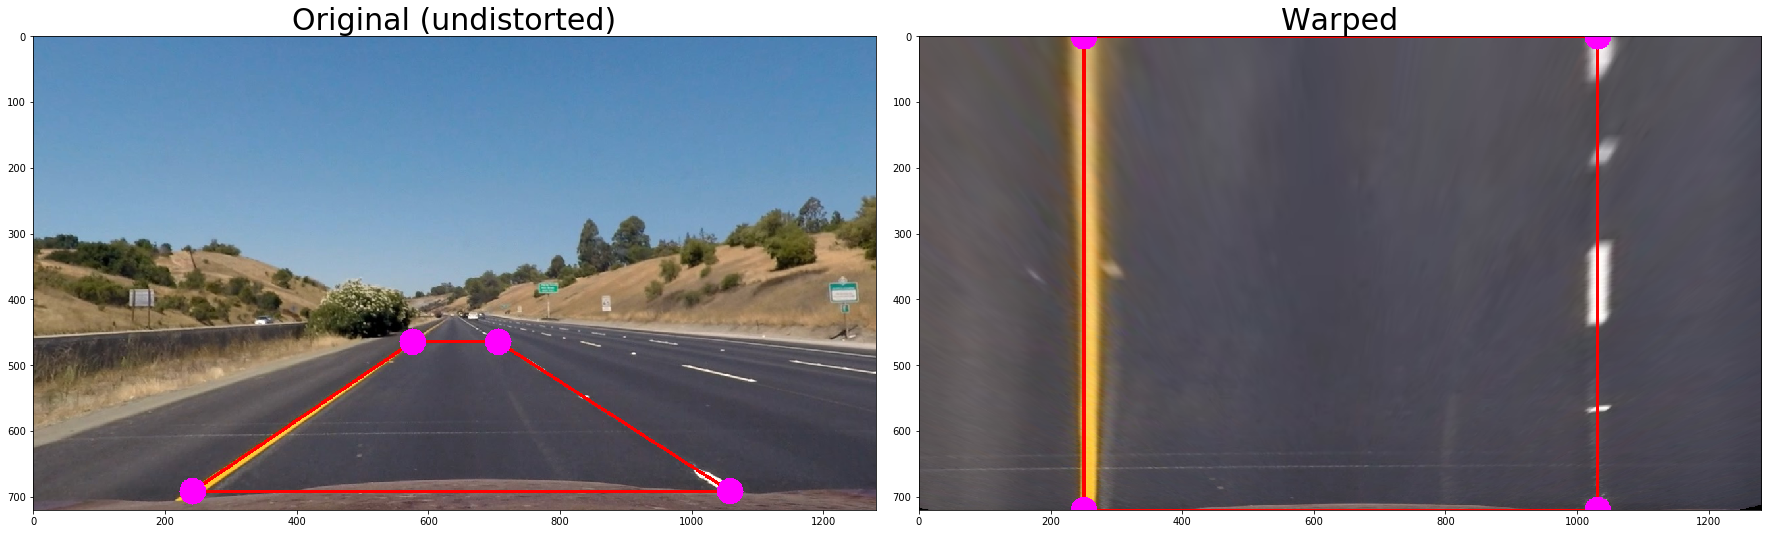

In [22]:
image_filename = 'data/images/straight_lines1.jpg'
img = mpimg.imread(image_filename)

lane_corners_from_undistorted_image = [(242,691), (1058, 691), (706, 464), (576, 464)]
dst = utils.rectangle_pts_inside_image(img, x_offset=250)

overlaid, warped, lanes_perspective_mat = camera.perform_perspective_transform(img, lane_corners_from_undistorted_image, dst, True)
utils.plot_images([(overlaid, 'Original (undistorted)'), (warped, 'Warped')])

plt.savefig('output/images/calibration/undistorted-lane-lines.jpg')

In [6]:
# Configuration for various videos
config.get_config("project-video")

{'image-shape': (720, 1280, 3),
 'polygon-window': {'margin': 100},
 'sliding-window': {'margin': 100, 'min-pix': 50, 'n-windows': 10},
 'thresholds': [Thresholdparams(color_space=53, channel_index=2, ch_threshold=(200, 255), sx_threshold=(15, 50)),
  Thresholdparams(color_space=None, channel_index=0, ch_threshold=(215, 255), sx_threshold=(15, 50))]}

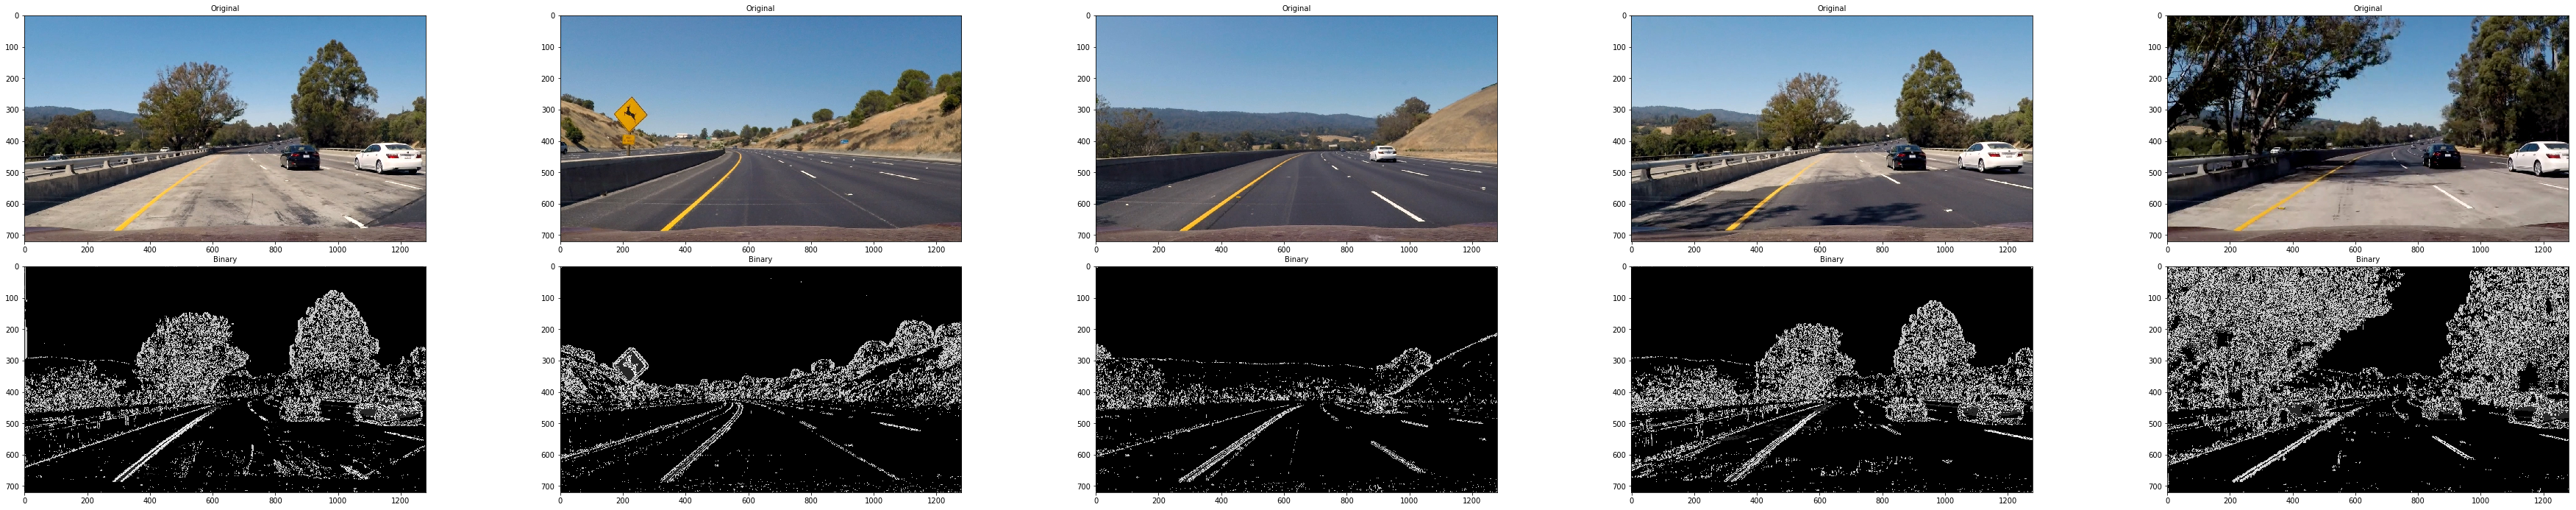

In [14]:
img_filenames = ['test1.jpg', 'test2.jpg', 'test3.jpg',  'test4.jpg',  'test5.jpg']

thresholder = thresholding.Thresholder(config.get_config('project-video')['thresholds'])

results = []
for filename in img_filenames:
    img = mpimg.imread('data/images/' + filename)
    binary = thresholder.threshold(img)
    results.append([(img, 'Original'), (binary, 'Binary')])
    
    out_file_prefix = 'output/images/thresholding/' + os.path.splitext(filename)[0]
    mpimg.imsave(out_file_prefix + '.original.jpg', img)
    mpimg.imsave(out_file_prefix + '.binary.jpg', binary, cmap='gray')
    
utils.plot_images(results,fig_size=(50,9))
plt.savefig('output/images/thresholding/thresholded-examples.jpg')

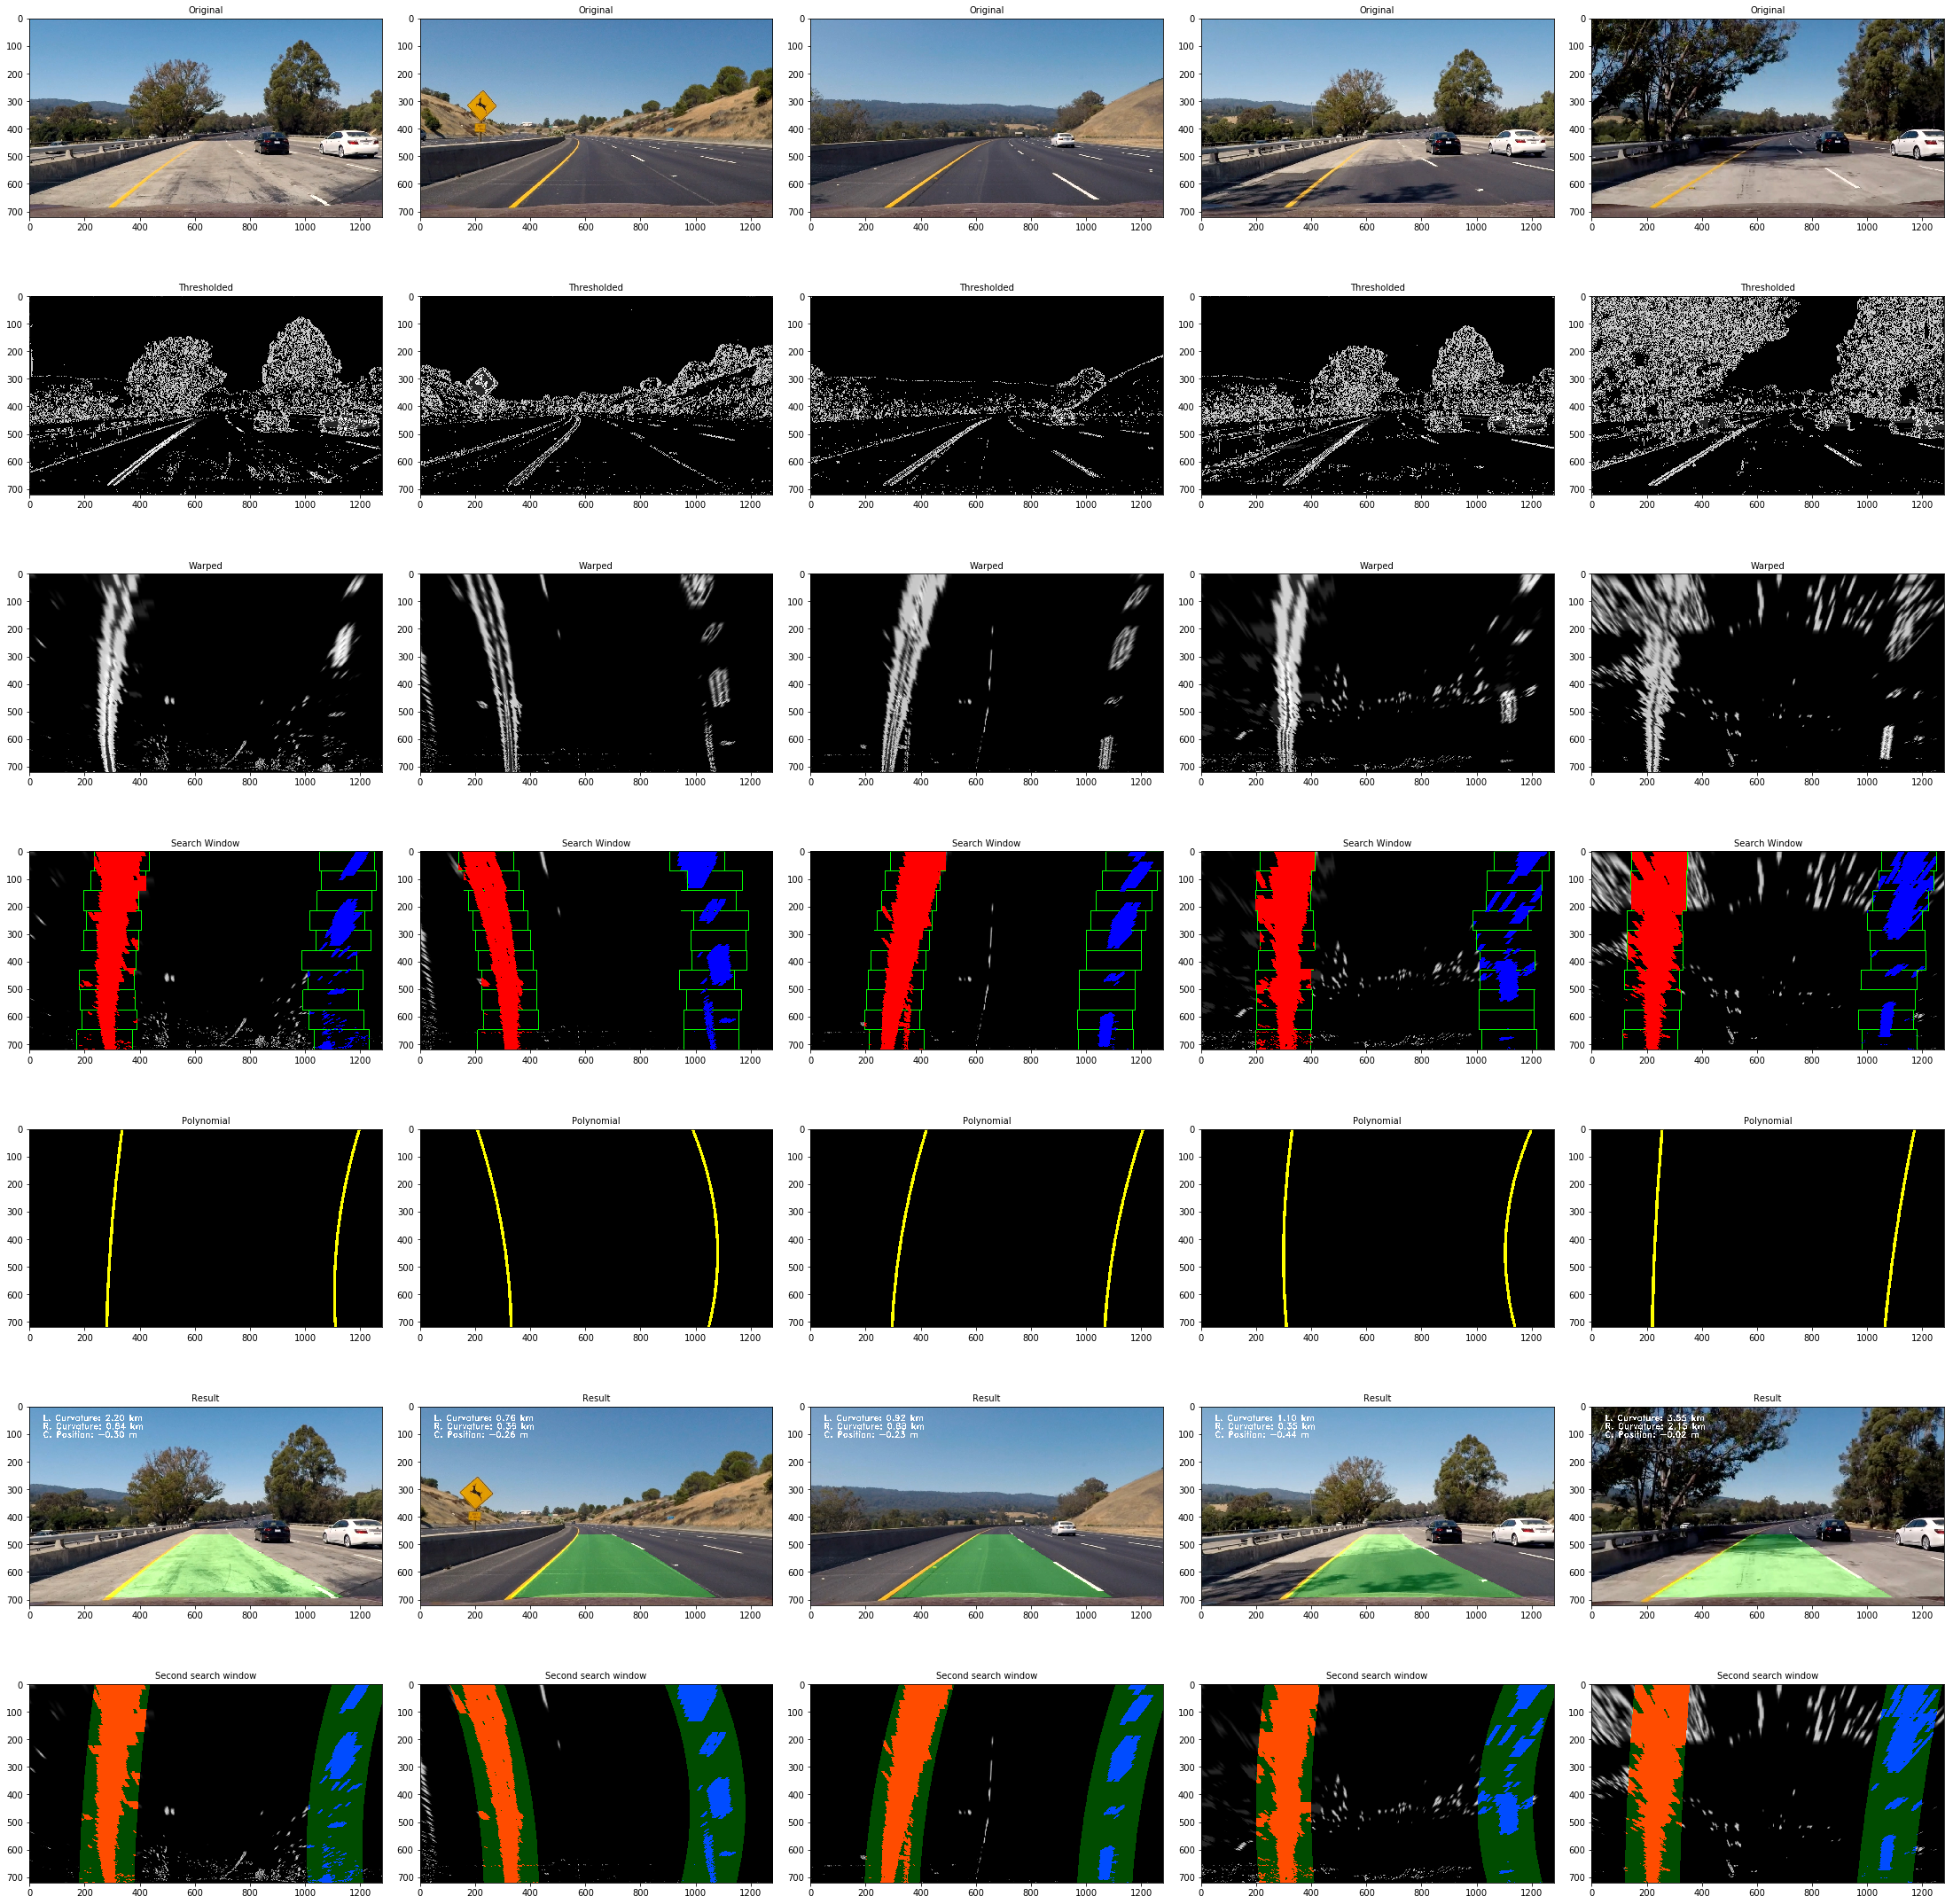

In [9]:
img_filenames = ['test1.jpg', 'test2.jpg', 'test3.jpg',  'test4.jpg',  'test5.jpg']

results = []
for filename in img_filenames:
    original = mpimg.imread('data/images/' + filename)
    
    detector = lane_detection.LaneDetector(camera, lanes_perspective_mat, "project-video")
    curvature, offset, (im_thresholded, im_warped, im_search_window, im_polynomial), result = detector.detect(original)
    
    # Detect again to see the search window change   
    _, _, (_, _, im_search_window_around_poly, _), _ = detector.detect(original)
    results.append([(original, 'Original'), (im_thresholded, 'Thresholded'), (im_warped, 'Warped'),
        (im_search_window, 'Search Window'), (im_polynomial, 'Polynomial'), (result, 'Result'), 
                    (im_search_window_around_poly, 'Second search window')
    ])
    
    out_file_prefix = 'output/images/lane-detection/' + os.path.splitext(filename)[0]
    mpimg.imsave(out_file_prefix + '.original.jpg', original)
    mpimg.imsave(out_file_prefix + '.thresholded.jpg', im_thresholded, cmap='gray')
    mpimg.imsave(out_file_prefix + '.warped.jpg', im_warped, cmap='gray')
    mpimg.imsave(out_file_prefix + '.search-window.jpg', im_search_window)
    mpimg.imsave(out_file_prefix + '.polynomial.jpg', im_polynomial)
    mpimg.imsave(out_file_prefix + '.result.jpg', result)
    mpimg.imsave(out_file_prefix + '.search-around-poly.jpg', im_search_window_around_poly)
    
utils.plot_images(results,fig_size=(30,30))


In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
detector = None
def pipeline(image):
    global detector
    if detector is None:
        detector = lane_detection.LaneDetector(camera, lanes_perspective_mat, "project-video")
    curvature, offset, interim_images, result = detector.detect(image)
    return result

project_video_output = 'output/videos/project_video.mp4'
project_clip = VideoFileClip("data/videos/project_video.mp4")
processed_project_video_clip = project_clip.fl_image(pipeline)
%time processed_project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output/videos/project_video.mp4
[MoviePy] Writing video output/videos/project_video.mp4


100%|█████████▉| 1260/1261 [05:40<00:00,  3.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/videos/project_video.mp4 

CPU times: user 9min 41s, sys: 56.5 s, total: 10min 38s
Wall time: 5min 42s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [13]:
detector = None
def pipeline(image):
    global detector
    if detector is None:
        detector = lane_detection.LaneDetector(camera, lanes_perspective_mat, "challenge-video")
    curvature, offset, interim_images, result = detector.detect(image)
    return result

challenge_video_output = 'output/videos/challenge_video.mp4'
challenge_clip = VideoFileClip("data/videos/challenge_video.mp4")
processed_challenge_video_clip = challenge_clip.fl_image(pipeline)
%time processed_challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video output/videos/challenge_video.mp4
[MoviePy] Writing video output/videos/challenge_video.mp4


100%|█████████▉| 484/485 [02:01<00:00,  3.98it/s]WARNING /Users/saga/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file data/videos/challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 485/485 [02:01<00:00,  3.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/videos/challenge_video.mp4 

CPU times: user 3min 32s, sys: 20.9 s, total: 3min 53s
Wall time: 2min 3s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [18]:
detector = None
def pipeline(image):
    global detector
    if detector is None:
        detector = lane_detection.LaneDetector(camera, lanes_perspective_mat, "harder-challenge-video")
    curvature, offset, interim_images, result = detector.detect(image)
    return result

harder_challenge_video_output = 'output/videos/harder_challenge_video.mp4'
harder_challenge_clip = VideoFileClip("data/videos/harder_challenge_video.mp4").subclip(0, 10)
processed_harder_challenge_video_clip = harder_challenge_clip.fl_image(pipeline)
%time processed_harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video output/videos/harder_challenge_video.mp4
[MoviePy] Writing video output/videos/harder_challenge_video.mp4



100%|█████████▉| 250/251 [01:12<00:00,  3.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/videos/harder_challenge_video.mp4 

CPU times: user 2min, sys: 11.3 s, total: 2min 12s
Wall time: 1min 15s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))